# Aggregating and weighting diverse data

In this notebook, we illustrate the aggregation of various data, and how to combine that with an adaptive scheme of computing weights.

The problem we face is that we can separate our summary statistics (=data) into subsets which are informative for different parameters, but the sizes of these subsets are not balanced. This happens frequently in practice, e.g. when one has a time series of 100 measurements, compared to a single data point. If these two statistics are informative for different parameters, then the impact of the first kind on the computed distance value can be overly high, and in addition the automatic weighting as introduced by Prangle 2017 may not reduce, or can indeed even worsen, the problem.

Thus, what we want to do is add additional "factors" by which we multiply each data point's weight. These factors take into account the number of summary statistics that are equally informative.

A toy model:

In [1]:
import pyabc
import numpy as np
import scipy as sp
import os
import tempfile
import matplotlib.pyplot as plt

N0 = 100
N1 = 1

p_true = {'p0': 5, 'p1': 10}

def model(p):
    ss = {}
    for j in range(N0):
        ss['p0_' + str(j)] = p['p0'] + sp.randn()
    for j in range(N1):
        ss['p1_' + str(j)] = p['p1'] + 0.1 * sp.randn()
    return ss

def model(p):
    ss = {}
    s0 = p['p0'] + sp.randn()
    for j in range(N0):
        ss['p0_' + str(j)] = s0
    s1 = p['p1'] + 0.1 * sp.randn()
    for j in range(N1):
        ss['p1_' + str(j)] = s1
    return ss

prior = pyabc.Distribution(p0=pyabc.RV("uniform", 0, 20),
                           p1=pyabc.RV("uniform", 0, 20))

/home/yannik/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


First, we consider uniform weights of 1:

In [2]:
distance = pyabc.PNormDistance(p=1)

abc = pyabc.ABCSMC(model, prior, distance)

observation = model(p_true)

db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
history1 = abc.run(max_nr_populations=10)

INFO:History:Start <ABCSMC(id=25, start_time=2019-09-25 06:38:12.969238, end_time=None)>
INFO:Epsilon:initial epsilon is 554.6223171481698
INFO:ABC:t:0 eps:554.6223171481698
INFO:ABC:t:1 eps:298.5812695816144
INFO:ABC:t:2 eps:165.32725843993356
INFO:ABC:t:3 eps:86.81184571983722
INFO:ABC:t:4 eps:37.22492142864448
INFO:ABC:t:5 eps:19.901715813935613
INFO:ABC:t:6 eps:14.626010037304763
INFO:ABC:t:7 eps:8.936343615882889
INFO:ABC:t:8 eps:6.182488144952231
INFO:ABC:t:9 eps:4.356755350149906
INFO:History:Done <ABCSMC(id=25, start_time=2019-09-25 06:38:12.969238, end_time=2019-09-25 06:39:08.390228)>


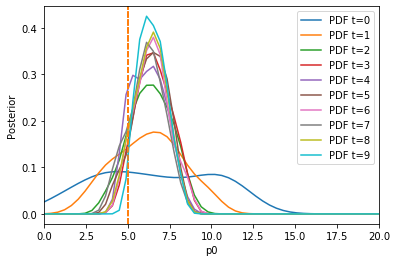

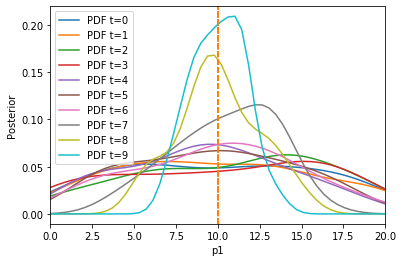

In [3]:
# plotting

def plot(history):
    fig, ax = plt.subplots()
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=20,
                                        x='p0', ax=ax,
                                        label="PDF t={}".format(t),
                                        refval=p_true)
    ax.legend()

    fig, ax = plt.subplots()
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=20,
                                        x='p1', ax=ax,
                                        label="PDF t={}".format(t),
                                        refval=p_true)
    ax.legend()
    
plot(history1)

Next, we account for the discrepancy in data point coutns by using factors:

INFO:History:Start <ABCSMC(id=26, start_time=2019-09-25 06:39:09.386592, end_time=None)>
INFO:Epsilon:initial epsilon is 11.120002294097109
INFO:ABC:t:0 eps:11.120002294097109
INFO:ABC:t:1 eps:7.48780831722268
INFO:ABC:t:2 eps:5.707904041665763
INFO:ABC:t:3 eps:4.184256801652109
INFO:ABC:t:4 eps:2.9465357351490837
INFO:ABC:t:5 eps:2.0751491176031607
INFO:ABC:t:6 eps:1.4776137303683574
INFO:ABC:t:7 eps:1.1600728050580809
INFO:ABC:t:8 eps:0.763690015110086
INFO:ABC:t:9 eps:0.5847795244592373
INFO:History:Done <ABCSMC(id=26, start_time=2019-09-25 06:39:09.386592, end_time=2019-09-25 06:39:43.283039)>


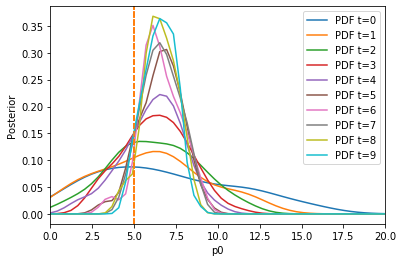

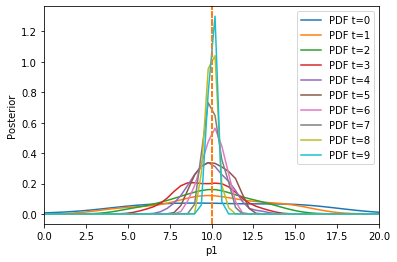

In [4]:
factors = {}
for j in range(N0):
    factors['p0_' + str(j)] = 1/N0
for j in range(N1):
    factors['p1_' + str(j)] = 1/N1
distance = pyabc.PNormDistance(p=1, factors=factors)

abc = pyabc.ABCSMC(model, prior, distance)

db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
history2 = abc.run(max_nr_populations=10)

plot(history2)

Next, we consider automatic weighting and factors:

INFO:History:Start <ABCSMC(id=27, start_time=2019-09-25 06:39:44.253940, end_time=None)>
DEBUG:Distance:updated weights[0] = {'p0_0': 0.99932252198914, 'p0_1': 0.99932252198914, 'p0_2': 0.99932252198914, 'p0_3': 0.99932252198914, 'p0_4': 0.99932252198914, 'p0_5': 0.99932252198914, 'p0_6': 0.99932252198914, 'p0_7': 0.99932252198914, 'p0_8': 0.99932252198914, 'p0_9': 0.99932252198914, 'p0_10': 0.99932252198914, 'p0_11': 0.99932252198914, 'p0_12': 0.99932252198914, 'p0_13': 0.99932252198914, 'p0_14': 0.99932252198914, 'p0_15': 0.99932252198914, 'p0_16': 0.99932252198914, 'p0_17': 0.99932252198914, 'p0_18': 0.99932252198914, 'p0_19': 0.99932252198914, 'p0_20': 0.99932252198914, 'p0_21': 0.99932252198914, 'p0_22': 0.99932252198914, 'p0_23': 0.99932252198914, 'p0_24': 0.99932252198914, 'p0_25': 0.99932252198914, 'p0_26': 0.99932252198914, 'p0_27': 0.99932252198914, 'p0_28': 0.99932252198914, 'p0_29': 0.99932252198914, 'p0_30': 0.99932252198914, 'p0_31': 0.99932252198914, 'p0_32': 0.999322521

INFO:ABC:t:2 eps:4.397782574589744
DEBUG:Distance:updated weights[3] = {'p0_0': 1.000005510115406, 'p0_1': 1.000005510115406, 'p0_2': 1.000005510115406, 'p0_3': 1.000005510115406, 'p0_4': 1.000005510115406, 'p0_5': 1.000005510115406, 'p0_6': 1.000005510115406, 'p0_7': 1.000005510115406, 'p0_8': 1.000005510115406, 'p0_9': 1.000005510115406, 'p0_10': 1.000005510115406, 'p0_11': 1.000005510115406, 'p0_12': 1.000005510115406, 'p0_13': 1.000005510115406, 'p0_14': 1.000005510115406, 'p0_15': 1.000005510115406, 'p0_16': 1.000005510115406, 'p0_17': 1.000005510115406, 'p0_18': 1.000005510115406, 'p0_19': 1.000005510115406, 'p0_20': 1.000005510115406, 'p0_21': 1.000005510115406, 'p0_22': 1.000005510115406, 'p0_23': 1.000005510115406, 'p0_24': 1.000005510115406, 'p0_25': 1.000005510115406, 'p0_26': 1.000005510115406, 'p0_27': 1.000005510115406, 'p0_28': 1.000005510115406, 'p0_29': 1.000005510115406, 'p0_30': 1.000005510115406, 'p0_31': 1.000005510115406, 'p0_32': 1.000005510115406, 'p0_33': 1.000

INFO:ABC:t:5 eps:2.4859811063099757
DEBUG:Distance:updated weights[6] = {'p0_0': 0.991957893205919, 'p0_1': 0.991957893205919, 'p0_2': 0.991957893205919, 'p0_3': 0.991957893205919, 'p0_4': 0.991957893205919, 'p0_5': 0.991957893205919, 'p0_6': 0.991957893205919, 'p0_7': 0.991957893205919, 'p0_8': 0.991957893205919, 'p0_9': 0.991957893205919, 'p0_10': 0.991957893205919, 'p0_11': 0.991957893205919, 'p0_12': 0.991957893205919, 'p0_13': 0.991957893205919, 'p0_14': 0.991957893205919, 'p0_15': 0.991957893205919, 'p0_16': 0.991957893205919, 'p0_17': 0.991957893205919, 'p0_18': 0.991957893205919, 'p0_19': 0.991957893205919, 'p0_20': 0.991957893205919, 'p0_21': 0.991957893205919, 'p0_22': 0.991957893205919, 'p0_23': 0.991957893205919, 'p0_24': 0.991957893205919, 'p0_25': 0.991957893205919, 'p0_26': 0.991957893205919, 'p0_27': 0.991957893205919, 'p0_28': 0.991957893205919, 'p0_29': 0.991957893205919, 'p0_30': 0.991957893205919, 'p0_31': 0.991957893205919, 'p0_32': 0.991957893205919, 'p0_33': 0.99

INFO:ABC:t:8 eps:1.9434262131747095
DEBUG:Distance:updated weights[9] = {'p0_0': 0.95808031139304, 'p0_1': 0.95808031139304, 'p0_2': 0.95808031139304, 'p0_3': 0.95808031139304, 'p0_4': 0.95808031139304, 'p0_5': 0.95808031139304, 'p0_6': 0.95808031139304, 'p0_7': 0.95808031139304, 'p0_8': 0.95808031139304, 'p0_9': 0.95808031139304, 'p0_10': 0.95808031139304, 'p0_11': 0.95808031139304, 'p0_12': 0.95808031139304, 'p0_13': 0.95808031139304, 'p0_14': 0.95808031139304, 'p0_15': 0.95808031139304, 'p0_16': 0.95808031139304, 'p0_17': 0.95808031139304, 'p0_18': 0.95808031139304, 'p0_19': 0.95808031139304, 'p0_20': 0.95808031139304, 'p0_21': 0.95808031139304, 'p0_22': 0.95808031139304, 'p0_23': 0.95808031139304, 'p0_24': 0.95808031139304, 'p0_25': 0.95808031139304, 'p0_26': 0.95808031139304, 'p0_27': 0.95808031139304, 'p0_28': 0.95808031139304, 'p0_29': 0.95808031139304, 'p0_30': 0.95808031139304, 'p0_31': 0.95808031139304, 'p0_32': 0.95808031139304, 'p0_33': 0.95808031139304, 'p0_34': 0.95808031

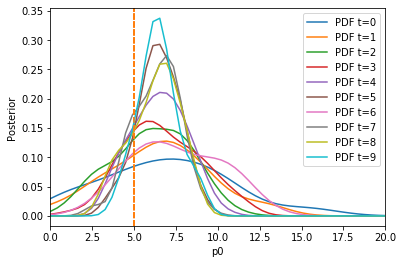

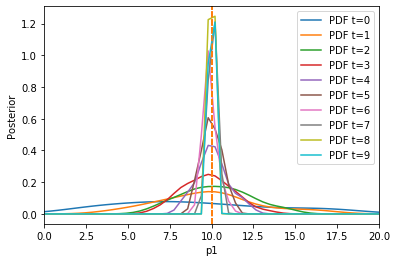

In [5]:
import logging
df_logger = logging.getLogger('Distance')
df_logger.setLevel(logging.DEBUG)

factors = {}
for j in range(N0):
    factors['p0_' + str(j)] = 1/N0
for j in range(N1):
    factors['p1_' + str(j)] = 1/N1
distance = pyabc.AdaptivePNormDistance(p=1, factors=factors)

abc = pyabc.ABCSMC(model, prior, distance)

db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
history3 = abc.run(max_nr_populations=10)

plot(history3)

Next, we use adaptive distances but no factors:

INFO:History:Start <ABCSMC(id=28, start_time=2019-09-25 06:40:20.190297, end_time=None)>
DEBUG:Distance:updated weights[0] = {'p0_0': 0.9993829590688, 'p0_1': 0.9993829590688, 'p0_2': 0.9993829590688, 'p0_3': 0.9993829590688, 'p0_4': 0.9993829590688, 'p0_5': 0.9993829590688, 'p0_6': 0.9993829590688, 'p0_7': 0.9993829590688, 'p0_8': 0.9993829590688, 'p0_9': 0.9993829590688, 'p0_10': 0.9993829590688, 'p0_11': 0.9993829590688, 'p0_12': 0.9993829590688, 'p0_13': 0.9993829590688, 'p0_14': 0.9993829590688, 'p0_15': 0.9993829590688, 'p0_16': 0.9993829590688, 'p0_17': 0.9993829590688, 'p0_18': 0.9993829590688, 'p0_19': 0.9993829590688, 'p0_20': 0.9993829590688, 'p0_21': 0.9993829590688, 'p0_22': 0.9993829590688, 'p0_23': 0.9993829590688, 'p0_24': 0.9993829590688, 'p0_25': 0.9993829590688, 'p0_26': 0.9993829590688, 'p0_27': 0.9993829590688, 'p0_28': 0.9993829590688, 'p0_29': 0.9993829590688, 'p0_30': 0.9993829590688, 'p0_31': 0.9993829590688, 'p0_32': 0.9993829590688, 'p0_33': 0.9993829590688, 

INFO:ABC:t:2 eps:172.1986605493418
DEBUG:Distance:updated weights[3] = {'p0_0': 1.0054371039879606, 'p0_1': 1.0054371039879606, 'p0_2': 1.0054371039879606, 'p0_3': 1.0054371039879606, 'p0_4': 1.0054371039879606, 'p0_5': 1.0054371039879606, 'p0_6': 1.0054371039879606, 'p0_7': 1.0054371039879606, 'p0_8': 1.0054371039879606, 'p0_9': 1.0054371039879606, 'p0_10': 1.0054371039879606, 'p0_11': 1.0054371039879606, 'p0_12': 1.0054371039879606, 'p0_13': 1.0054371039879606, 'p0_14': 1.0054371039879606, 'p0_15': 1.0054371039879606, 'p0_16': 1.0054371039879606, 'p0_17': 1.0054371039879606, 'p0_18': 1.0054371039879606, 'p0_19': 1.0054371039879606, 'p0_20': 1.0054371039879606, 'p0_21': 1.0054371039879606, 'p0_22': 1.0054371039879606, 'p0_23': 1.0054371039879606, 'p0_24': 1.0054371039879606, 'p0_25': 1.0054371039879606, 'p0_26': 1.0054371039879606, 'p0_27': 1.0054371039879606, 'p0_28': 1.0054371039879606, 'p0_29': 1.0054371039879606, 'p0_30': 1.0054371039879606, 'p0_31': 1.0054371039879606, 'p0_32': 1

INFO:ABC:t:5 eps:24.71540363079748
DEBUG:Distance:updated weights[6] = {'p0_0': 1.006857826310292, 'p0_1': 1.006857826310292, 'p0_2': 1.006857826310292, 'p0_3': 1.006857826310292, 'p0_4': 1.006857826310292, 'p0_5': 1.006857826310292, 'p0_6': 1.006857826310292, 'p0_7': 1.006857826310292, 'p0_8': 1.006857826310292, 'p0_9': 1.006857826310292, 'p0_10': 1.006857826310292, 'p0_11': 1.006857826310292, 'p0_12': 1.006857826310292, 'p0_13': 1.006857826310292, 'p0_14': 1.006857826310292, 'p0_15': 1.006857826310292, 'p0_16': 1.006857826310292, 'p0_17': 1.006857826310292, 'p0_18': 1.006857826310292, 'p0_19': 1.006857826310292, 'p0_20': 1.006857826310292, 'p0_21': 1.006857826310292, 'p0_22': 1.006857826310292, 'p0_23': 1.006857826310292, 'p0_24': 1.006857826310292, 'p0_25': 1.006857826310292, 'p0_26': 1.006857826310292, 'p0_27': 1.006857826310292, 'p0_28': 1.006857826310292, 'p0_29': 1.006857826310292, 'p0_30': 1.006857826310292, 'p0_31': 1.006857826310292, 'p0_32': 1.006857826310292, 'p0_33': 1.006

INFO:ABC:t:8 eps:4.458246509462571
DEBUG:Distance:updated weights[9] = {'p0_0': 1.0072466109068416, 'p0_1': 1.0072466109068416, 'p0_2': 1.0072466109068416, 'p0_3': 1.0072466109068416, 'p0_4': 1.0072466109068416, 'p0_5': 1.0072466109068416, 'p0_6': 1.0072466109068416, 'p0_7': 1.0072466109068416, 'p0_8': 1.0072466109068416, 'p0_9': 1.0072466109068416, 'p0_10': 1.0072466109068416, 'p0_11': 1.0072466109068416, 'p0_12': 1.0072466109068416, 'p0_13': 1.0072466109068416, 'p0_14': 1.0072466109068416, 'p0_15': 1.0072466109068416, 'p0_16': 1.0072466109068416, 'p0_17': 1.0072466109068416, 'p0_18': 1.0072466109068416, 'p0_19': 1.0072466109068416, 'p0_20': 1.0072466109068416, 'p0_21': 1.0072466109068416, 'p0_22': 1.0072466109068416, 'p0_23': 1.0072466109068416, 'p0_24': 1.0072466109068416, 'p0_25': 1.0072466109068416, 'p0_26': 1.0072466109068416, 'p0_27': 1.0072466109068416, 'p0_28': 1.0072466109068416, 'p0_29': 1.0072466109068416, 'p0_30': 1.0072466109068416, 'p0_31': 1.0072466109068416, 'p0_32': 1

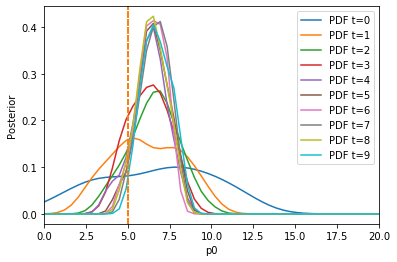

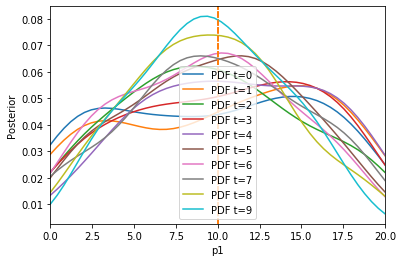

In [6]:
distance = pyabc.AdaptivePNormDistance(p=1, )#factors=factors)

abc = pyabc.ABCSMC(model, prior, distance)

db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
history4 = abc.run(max_nr_populations=10)

plot(history4)

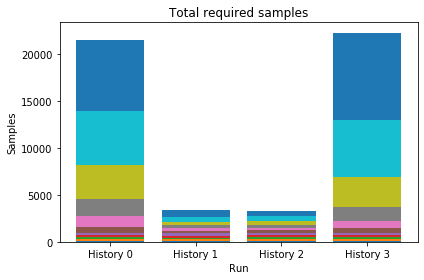

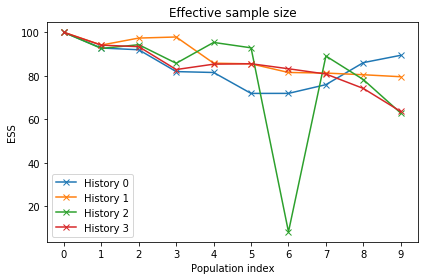

In [8]:
pyabc.visualization.plot_sample_numbers([history1, history2, history3, history4])
pyabc.visualization.plot_effective_sample_sizes([history1, history2, history3, history4])